In [1]:
import mlflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlflow.tracking import MlflowClient
from mlflow.entities import ViewType
import matplotlib.ticker as tick
from matplotlib.dates import DateFormatter
from datetime import datetime, timedelta
from pathlib import Path
from pydash import py_
from green_city.utils import datetime2index, index2datetime

from green_city.mlflow_config import get_mlflow_config
mlflow.set_tracking_uri(get_mlflow_config()["TRACKING_URI"])
client = MlflowClient()
experiment_id = client.get_experiment_by_name("green_city_experiments").experiment_id

## DB CONNECTION ##
from sqlalchemy import create_engine
from decouple import Config, RepositoryEnv

config = Config(RepositoryEnv("../.db_credentials"))

db_connection_credentials = {
    "database": config('POSTGRES_DB'),
    "user": config('POSTGRES_USER'),
    "password": config('POSTGRES_PASSWORD'),
    "host": config('POSTGRES_HOST'),
    "port": config('POSTGRES_PORT'),
}
DB_STRING = "postgresql://{user}:{password}@{host}:{port}/{database}".format(**db_connection_credentials)
db = create_engine(DB_STRING)

Fontconfig warning: ignoring UTF-8: not a valid region tag


In [2]:
#global configuration
BUILDING_NR = "all"
USE_ROOT = True #RMSE insead of MSE

indices = [32135, 33311, 26478, 33357, 30387, 30794, 31800, 28783]
INDEX_LINEPLOT = indices[7]

##########################################################
#df.loc[df["run_name"] == "Prophet Simple Model", "model"] = "prophet"
#df.loc[df["run_name"] == "Prophet Simple Model Optimized Parameters", "model"] = "prophet"
#    if df_row["run_name"] == "Prophet Simple Model":
#        return "Prophet"
#df[df["run_name"] == "Prophet Simple Model"].index
##########################################################
#    plot_df = plot_df[plot_df["run_name"] != "sarimax_(6,1,1)(0,0,2,24)"]
#    plot_df = plot_df[plot_df["disp_label"].map(lambda x: x in ("Linear regression", "Sarimax", "Prophet", "TBATS", "ARIMA", "Baseline"))]
##########################################################


selectors = {
    'baseline': {
        'select__model': 'baseline',
        'disp_color': 'orange',
        'disp_label': 'Baseline',
    },
    'linear_regression': {
        'select__run_name': 'linear_regression', #wouldn't need both selectors actually
        'select__model': 'linear_regression',
        'disp_color': '#7BC8F6',
        'disp_label': 'Linear regression',
    },
    'tbats': {
        'select__run_name': 'TBATS_1000',
        'select__model': 'TBATS',
        'disp_color': 'blue',
        'disp_label': 'TBATS',
    },
    #'arima': {
    #    'select__model': 'ARIMA',
    #    'disp_color': 'purple',
    #    'disp_label': 'ARIMA',
    #},
    'sarimax': {
        'select__model': 'sarimax',
        'exclude__run_name': 'sarimax_(6,1,1)(0,0,2,24)',
        'disp_color': '#FF7F50',
        'disp_label': 'SARIMAX',
    },
    'prophet_1': {
        'select__run_name': 'Prophet Holidays-Wkl-Regressors-Optimized-Parameters - Tunning with MSE',
        'disp_color': 'purple',
        'disp_label': 'Prophet',
        #'disp_style': 'dashed',
    },
    #'prophet_2': {
    #    'select__run_name': 'Prophet Holidays-Regressors-Optimized-Parameters - Tunning with MSE',
    #    'disp_color': 'purple',
    #    'disp_label': 'Prophet 2',
    #},
    #'prophet_3': {
    #    'select__run_name': 'Prophet Holidays-Optimized-Parameters - Tunning with MSE',
    #    'disp_color': 'purple',
    #    'disp_label': 'Prophet 3',
    #},
    #'prophet_4': {
    #    'select__run_name': 'Prophet Simple Model Optimized Parameters - Tunning with MSE',
    #    'disp_color': 'purple',
    #    'disp_label': 'Prophet 4',
    #},
    #'prophet_5': {
    #    'select__run_name': 'Prophet Simple Model',
    #    'disp_color': 'purple',
    #    'disp_label': 'Prophet 5',
    #},
    'random_forest': {
        'select__run_name': 'random_forest',
        'disp_color': 'green',
        'disp_label': 'Random forest',
    },
    'poly_regression': {
        'select__run_name': 'poly_regression',
        'disp_color': '#FFD700',
        'disp_label': 'Polynomial regression',
    },
    'xgb': {
        'select__run_name': 'XGBoost_reduced_features',
        'disp_color': '#06C2FC',
        'disp_label': 'XGBoost',
    },
    #'xgb_optimized': {
    #    'select__run_name': 'XGB_optimized',
    #    'disp_color': '#06C2AC',
    #    'disp_label': 'XGBoost',
    #},
    #'xgb_simple': {
    #    'select__run_name': 'XGB_simple',
    #    'disp_color': 'cyan',
    #    'disp_label': 'XGB simple',
    #},
}

def select(run_info):
    for name, di in selectors.items():
        is_match = True
        for select_key in filter(lambda x: 'select__' in x, di.keys()):
            key = select_key.split('__')[1]
            if run_info.get(key) != di[select_key]:
                is_match = False
                break
        for exclude_key in filter(lambda x: 'exclude__' in x, di.keys()):
            key = exclude_key.split('__')[1]
            if run_info.get(key) == di[exclude_key]:
                is_match = False
                break
        if is_match:
            return (name, dict([(k, v) for k, v in di.items() if k in ['disp_color', 'disp_label'] ]))
    return (None, None)


In [3]:
run_ids = [r.run_id for r in client.list_run_infos(experiment_id, run_view_type=ViewType.ACTIVE_ONLY)]

all_runs = {run_id: client.get_run(run_id).to_dictionary() for run_id in run_ids}

In [4]:
runs_dict = {}

for id, details in all_runs.items():
    start_time = py_.get(details, "info.start_time")
    end_time = py_.get(details, "info.end_time")
    #delta = round(end_time/1000 - start_time/1000, 2)

    #filter by buildings
    params = py_.get(details, "data.params")

    if len(params) == 0: #probably currently active run
        continue
    
    runs_dict_id = {
        #"time_s": delta,
        **py_.get(details, "data.metrics"),
        **py_.get(details, "data.params"),
        "run_name": details["data"]["tags"]["mlflow.runName"],
    }

    if (runs_dict_id.get("building nr") and not runs_dict_id.get("building_nr")):
        runs_dict_id["building_nr"] = runs_dict_id.pop("building nr")
    
    assert 'building nr' not in runs_dict_id.keys()
    assert 'building_nr' in runs_dict_id.keys()

    #selection 1: building nr
    if BUILDING_NR is not None:
        if BUILDING_NR.lower() != runs_dict_id['building_nr'].lower():
            continue

    #selection 2: models to include
    selection_name, additional_properties = select(runs_dict_id)
    if selection_name is not None:
        runs_dict_id.update(additional_properties)
        runs_dict_id["name"] = selection_name
    else:
        continue

    runs_dict[id] = runs_dict_id

In [5]:
df = pd.DataFrame.from_dict(runs_dict, orient='index')
df = df.astype({"datetime": "datetime64[ns]"})
df = df.assign(index = df['index'].fillna(df.datetime.map(datetime2index))).dropna(subset=["index"])

#if index is not set, assign it from datetime
df.datetime.map(datetime2index).unique()
df = df.astype({"index": "int", "train_steps": "float"})
df.index = df.index.rename("run_id")

In [6]:
print(len(df))
df

66


,mae,mse,r2_score,datetime,building_nr,feature,predicted_feature,model,resolution,run_name,disp_color,disp_label,name,pred_steps,index,train_steps,seasonalities
run_id,,,,,,,,,,,,,,,,,
c1f493da16184e8089a1ff02744ba4ee,23.376287,985.511974,0.834929,2011-04-15 07:00:00,all,net_load_kW,net_load_kWh,random_forest,daily,random_forest,green,Random forest,random_forest,NaN,28783,NaN,NaN
b7f43c64acd34a6cb2127a77fa71c658,37.235494,2214.999709,0.948003,2011-08-19 00:00:00,all,net_load_kW,net_load_kWh,random_forest,daily,random_forest,green,Random forest,random_forest,NaN,31800,NaN,NaN
a8b82084bd224516ad6c6ee0b27a22f6,24.887067,1302.495075,0.939924,2011-07-08 02:00:00,all,net_load_kW,net_load_kWh,random_forest,daily,random_forest,green,Random forest,random_forest,NaN,30794,NaN,NaN
2752f3c0f3094bef838ba5e516ec19b5,34.543945,1778.115017,0.921653,2011-06-21 03:00:00,all,net_load_kW,net_load_kWh,random_forest,daily,random_forest,green,Random forest,random_forest,NaN,30387,NaN,NaN
330229d700e648a0963d157249319784,23.011309,696.377936,0.755799,2011-10-22 21:00:00,all,net_load_kW,net_load_kWh,random_forest,daily,random_forest,green,Random forest,random_forest,NaN,33357,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
e8795df644d0440794f347d6868d9275,55.500602,3867.051162,0.829610,2011-06-21 03:00:00,all,net_load_kW,net_load_kW,linear_regression,daily,linear_regression,#7BC8F6,Linear regression,linear_regression,NaN,30387,NaN,NaN
4060aa4244834423a36dfec625ea7357,32.595558,1471.190642,0.484093,2011-10-22 21:00:00,all,net_load_kW,net_load_kW,linear_regression,daily,linear_regression,#7BC8F6,Linear regression,linear_regression,NaN,33357,NaN,NaN
d9c5f473d54245ba8280060cc2037365,38.249077,2360.073649,-0.233557,2011-01-09 06:00:00,all,net_load_kW,net_load_kW,linear_regression,daily,linear_regression,#7BC8F6,Linear regression,linear_regression,NaN,26478,NaN,NaN


In [7]:
#plt.rcParams['figure.figsize'] = [25, 8]
#df[df.feature=="net_load_kWh"].loc[:, ["mae", "mse", "r2_score"]].plot.barh()
#df[df.feature=="net_load_kWh"].loc[:, ["time_s"]].plot.barh()
df.to_csv("../data/results/evaluation_matrix.csv")

,model,time_index,run_index,mse,mae,rmse
0,baseline,32135,0a8a0d707b6944028e19dc44fd851201,39081.913321,174.511625,197.691460
1,poly_regression,32135,9a8a8dd8442e43acbe280af66db9a06f,4388.183803,52.165330,66.243368
2,sarimax,32135,c2ad6939b10d453385d90c225fc61ecc,4024.085812,54.508734,63.435682
3,random_forest,32135,2732a6c023d541f28be230104f71dd89,3747.222570,47.630728,61.214562
4,linear_regression,32135,823feded65e641bd890df2f9d42e5b18,3578.475105,49.989447,59.820357
...,...,...,...,...,...,...
59,tbats,28783,4b36430d49784362abbb0020ab9ff0d1,1543.459403,31.023719,39.286886
60,baseline,28783,045d59b8b579407f93eb15ba47098e63,1380.228723,26.726042,37.151430
61,sarimax,28783,e07c82fe55524d06a1c57621f044d3e3,1251.039265,27.814511,35.370033
62,xgb,28783,6df9fba4b3aa4f9ba446c87fc250ec3a,995.565369,23.570592,31.552581


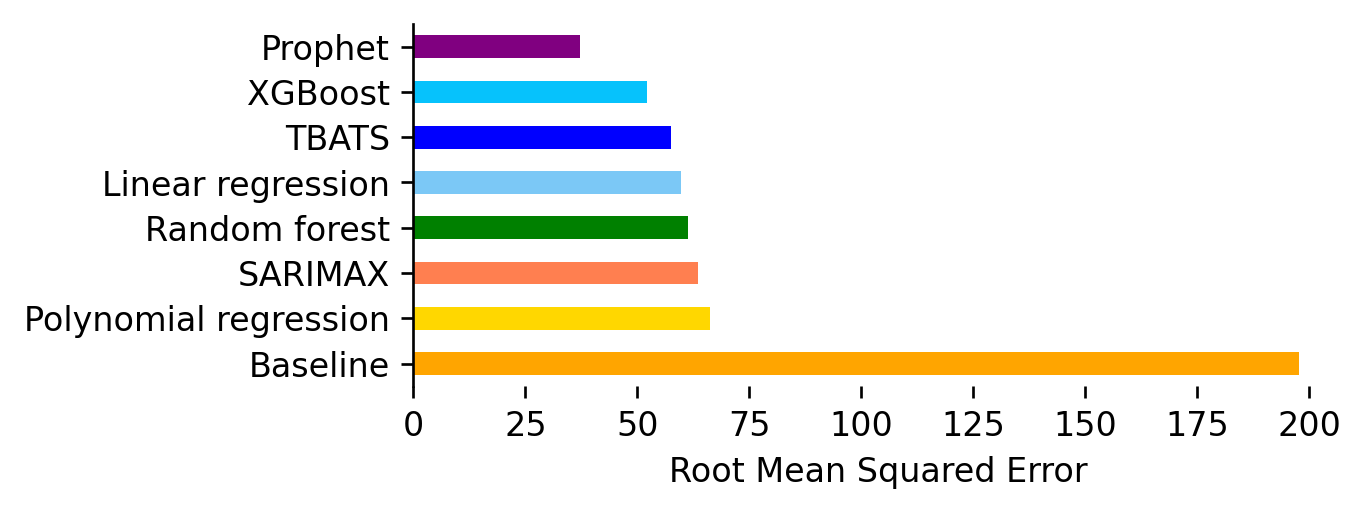

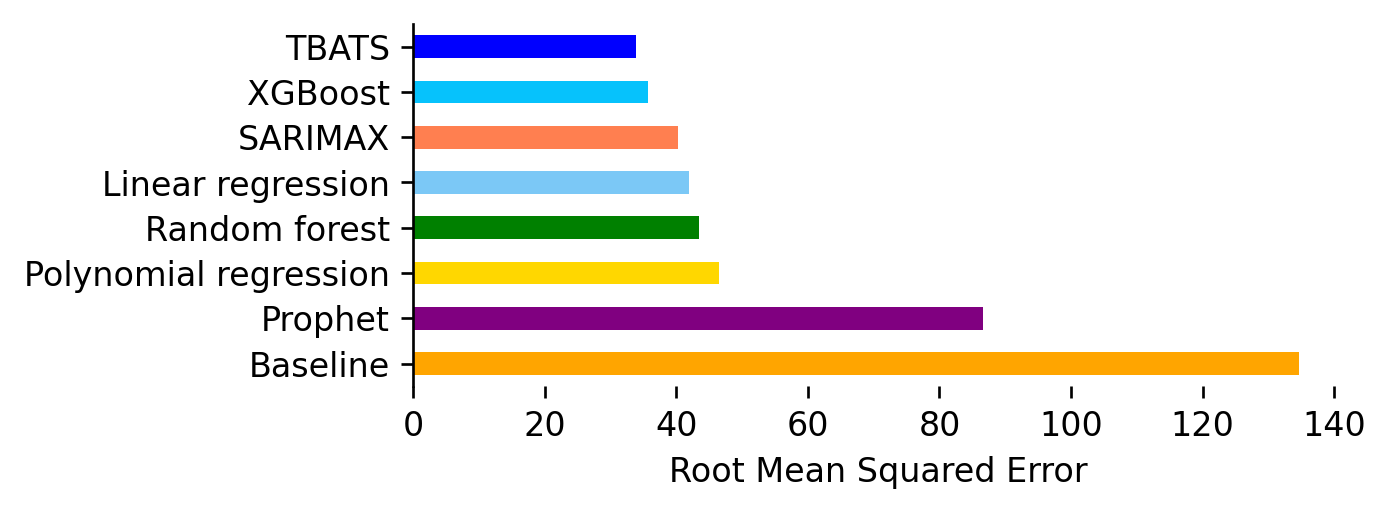

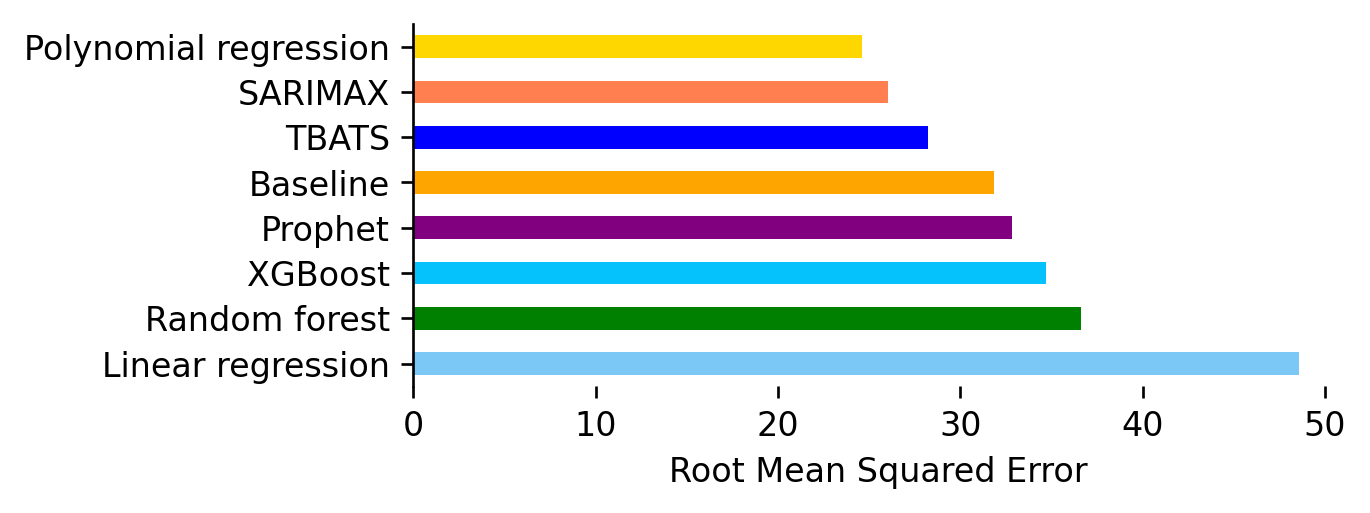

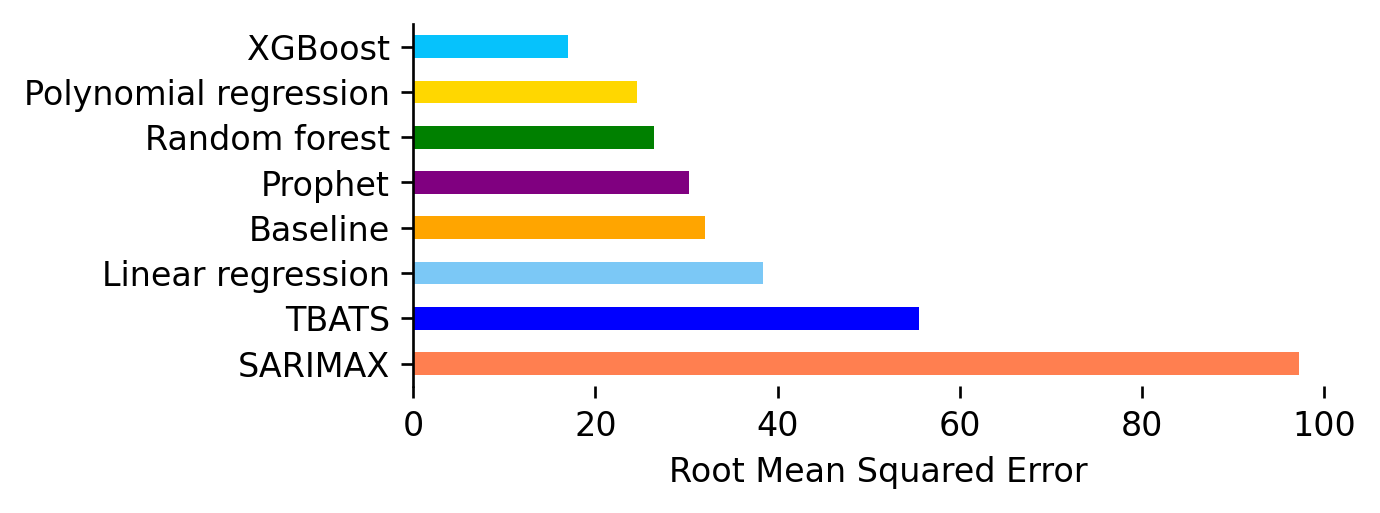

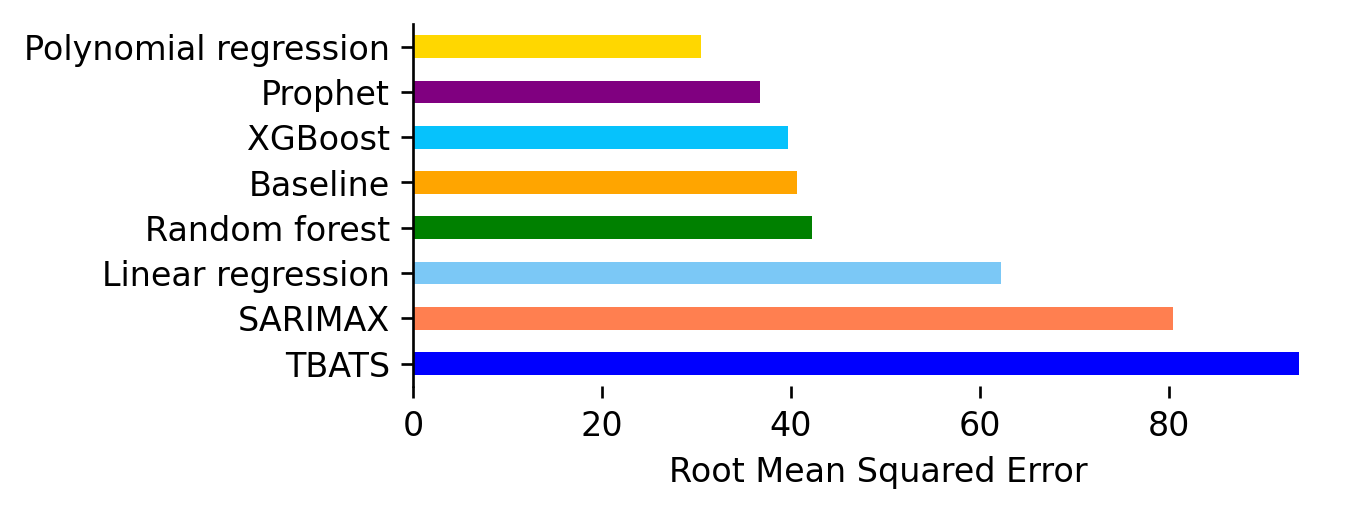

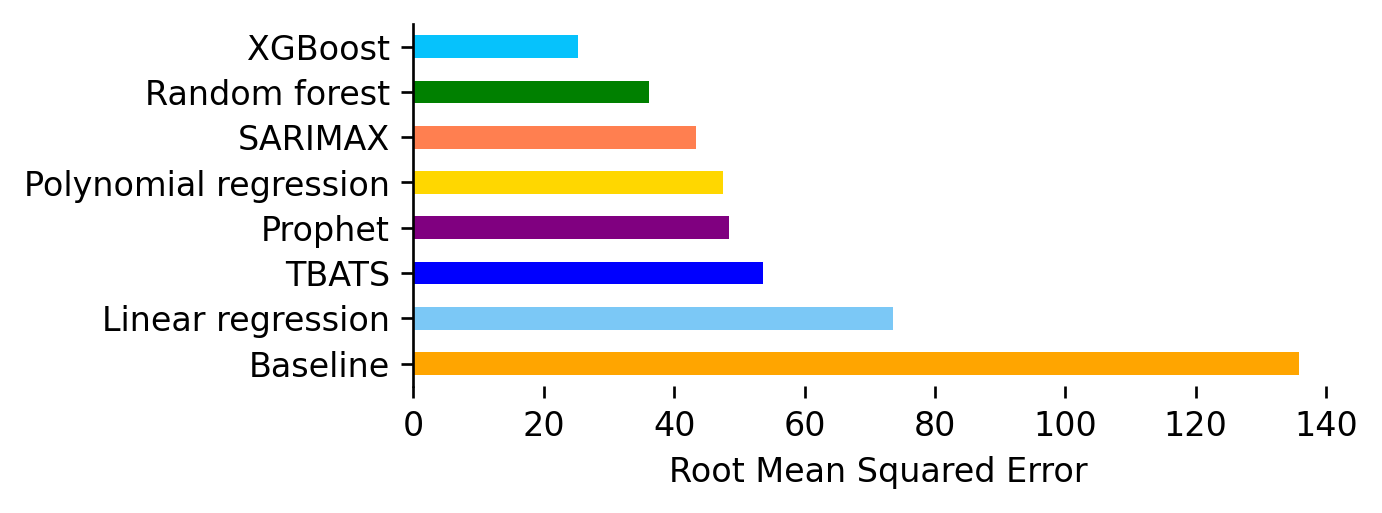

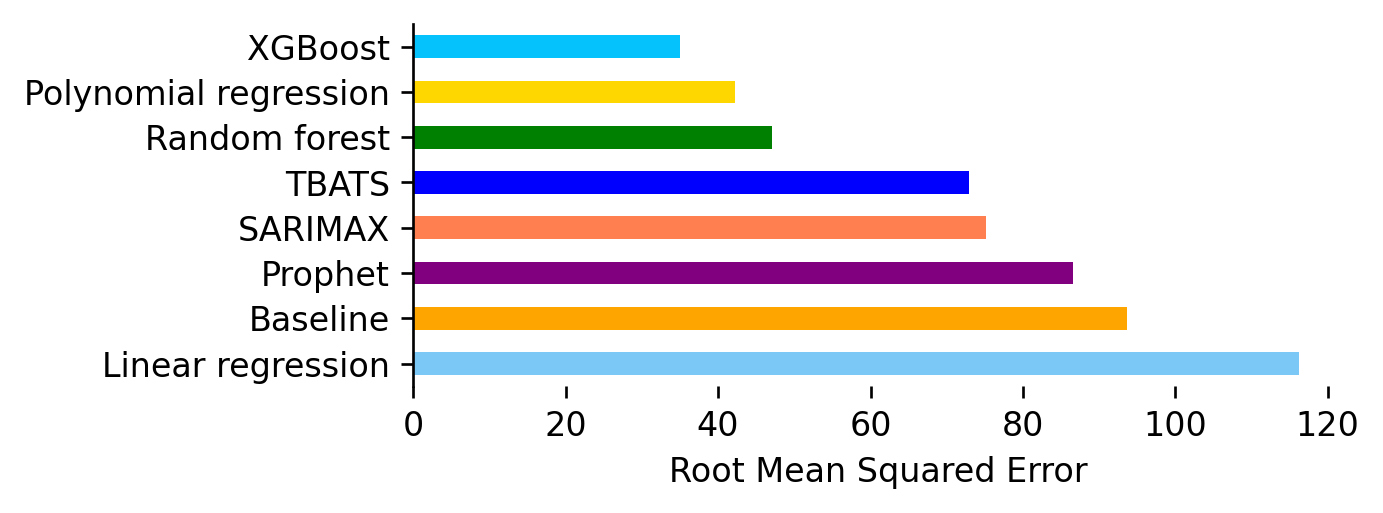

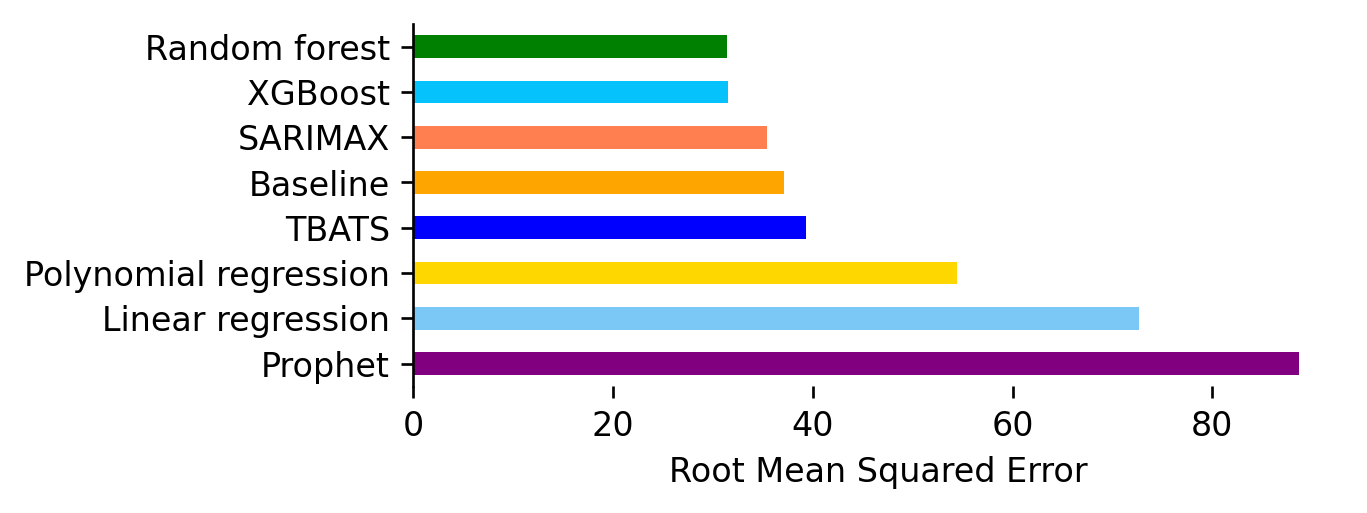

In [8]:
plt.rcParams['figure.figsize'] = [12, 4]

#TODO: take keys from selection dictionary or from actual used names.
#all_performances = {
#    "baseline": [],
#    "linear_regression": [],
#    "TBATS": [],
#    "sarimax": [],
#    "ARIMA": [],
#    "prophet": [],
#}
all_performances = {k: [] for k in selectors.keys()}

all_performances_dicts = []


for index in indices:
    fig, ax = plt.subplots()
    fig.set_figheight(2)
    fig.set_figwidth(5)
    fig.set_dpi(240)

    plot_df = (df[df["index"] == index]
                .sort_values("mse", ascending=False)
                #.assign(col = lambda x:x["model"].map(lambda x: model2color.get(x, "black")))
                #.assign(label = lambda x: f"{x['model']}{steps2str(x['train_steps'])}")
                .drop_duplicates(subset=["run_name", "model"])
    )
    plot_df["rmse"] = np.sqrt(plot_df["mse"])

    
    for idx, benchmark in plot_df.iterrows():
        all_performances[benchmark["name"]].append(benchmark["mse"])
        all_performances_dicts.append({
            'model': [benchmark['name']],
            'time_index': [index],
            'run_index': [idx],
            'mse': [benchmark['mse']],
            'mae': [benchmark['mae']],
            'rmse': [benchmark['rmse']],
        })
    
    if USE_ROOT:
        score_col = "rmse"
    else:
        score_col = "mse"
    plot_df.plot.barh(x="disp_label", y=score_col, color=plot_df["disp_color"], legend=None, ax=ax)
    #ax.barh(plot_df["mse"], width=20, color=plot_df["col"], legend=None, height=0.9)
    axis_label = "Root Mean Squared Error" if USE_ROOT else "Mean squared error"
    ax.set_xlabel(axis_label)
    ax.set_ylabel(None)
    #fig.suptitle(f"{str(index2datetime(index+1))} to {str(index2datetime(index+24))}")
    fig.suptitle("")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

all_performances_df = pd.DataFrame({
    'model': [],
    'time_index': [],
    'mse': [],
    'mae': [],
    'rmse': [],
})
all_performances_df = pd.concat([pd.DataFrame(di) for di in all_performances_dicts], ignore_index=True)
all_performances_df

In [9]:
all_performances_df["disp_color"] = all_performances_df.model.map(lambda x: selectors[x]["disp_color"])
all_performances_df["disp_label"] = all_performances_df.model.map(lambda x: selectors[x]["disp_label"])
all_performances_df

,model,time_index,run_index,mse,mae,rmse,disp_color,disp_label
0,baseline,32135,0a8a0d707b6944028e19dc44fd851201,39081.913321,174.511625,197.691460,orange,Baseline
1,poly_regression,32135,9a8a8dd8442e43acbe280af66db9a06f,4388.183803,52.165330,66.243368,#FFD700,Polynomial regression
2,sarimax,32135,c2ad6939b10d453385d90c225fc61ecc,4024.085812,54.508734,63.435682,#FF7F50,SARIMAX
3,random_forest,32135,2732a6c023d541f28be230104f71dd89,3747.222570,47.630728,61.214562,green,Random forest
4,linear_regression,32135,823feded65e641bd890df2f9d42e5b18,3578.475105,49.989447,59.820357,#7BC8F6,Linear regression
...,...,...,...,...,...,...,...,...
59,tbats,28783,4b36430d49784362abbb0020ab9ff0d1,1543.459403,31.023719,39.286886,blue,TBATS
60,baseline,28783,045d59b8b579407f93eb15ba47098e63,1380.228723,26.726042,37.151430,orange,Baseline
61,sarimax,28783,e07c82fe55524d06a1c57621f044d3e3,1251.039265,27.814511,35.370033,#FF7F50,SARIMAX
62,xgb,28783,6df9fba4b3aa4f9ba446c87fc250ec3a,995.565369,23.570592,31.552581,#06C2FC,XGBoost


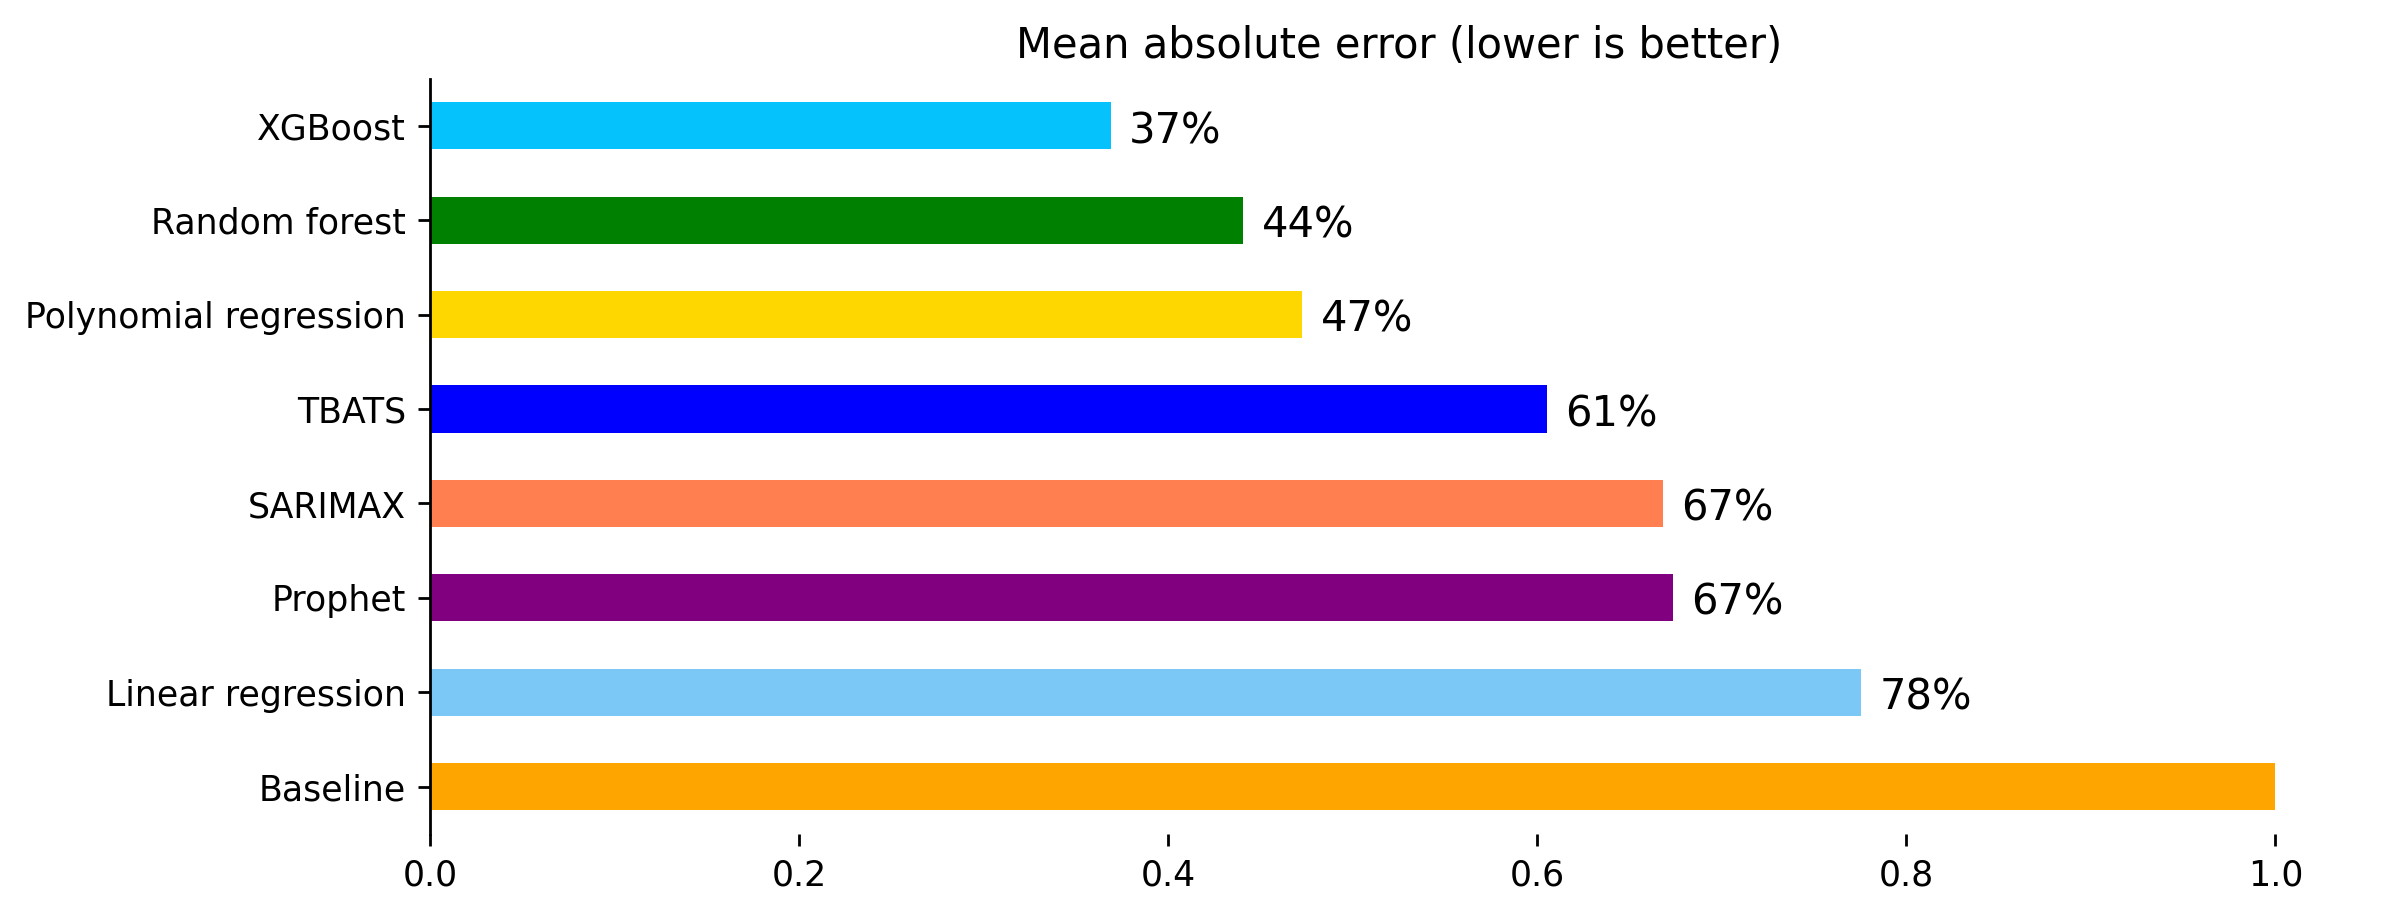

In [10]:
from matplotlib.pyplot import xlabel

agg_performances = all_performances_df.groupby("model").mean().sort_values("mae", ascending=False)
agg_performances["disp_color"] = agg_performances.index.map(lambda x: selectors[x]["disp_color"])
agg_performances["disp_label"] =  agg_performances.index.map(lambda x: selectors[x]["disp_label"])
baseline_score = agg_performances[agg_performances.index == "baseline"]["rmse"].values[0]
baseline_score_mse = agg_performances[agg_performances.index == "baseline"]["mse"].values[0]
baseline_score_mae = agg_performances[agg_performances.index == "baseline"]["mae"].values[0]
agg_performances["relative_rmse"] = agg_performances.rmse.map(lambda x: x/baseline_score)
agg_performances["relative_mse"] = agg_performances.mse.map(lambda x: x/baseline_score_mse)
agg_performances["relative_mae"] = agg_performances.mae.map(lambda x: x/baseline_score_mae)
agg_performances
fig, ax = plt.subplots(figsize=(10,4))
agg_performances.plot.barh(
    x="disp_label",
    #y="relative_mse",
    y="relative_mae",
    #label="relative_rmse",
    color=agg_performances.disp_color,
    title="Mean absolute error (lower is better)",
    xlabel="",
    legend=None,
    ax=ax);
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

for i, (model_index, model_info) in enumerate(agg_performances.iterrows()):
    if model_index == "baseline":
        continue
    x = model_info.relative_mae
    y = i
    #ax.text(x+0.01, y-0.1, f"{100*model_info.relative_mae:.0f}%", color=model_info.disp_color, size=14)
    ax.text(x+0.01, y-0.18, f"{100*model_info.relative_mae:.0f}%", color="black", size=12)

fig.set_dpi(250)

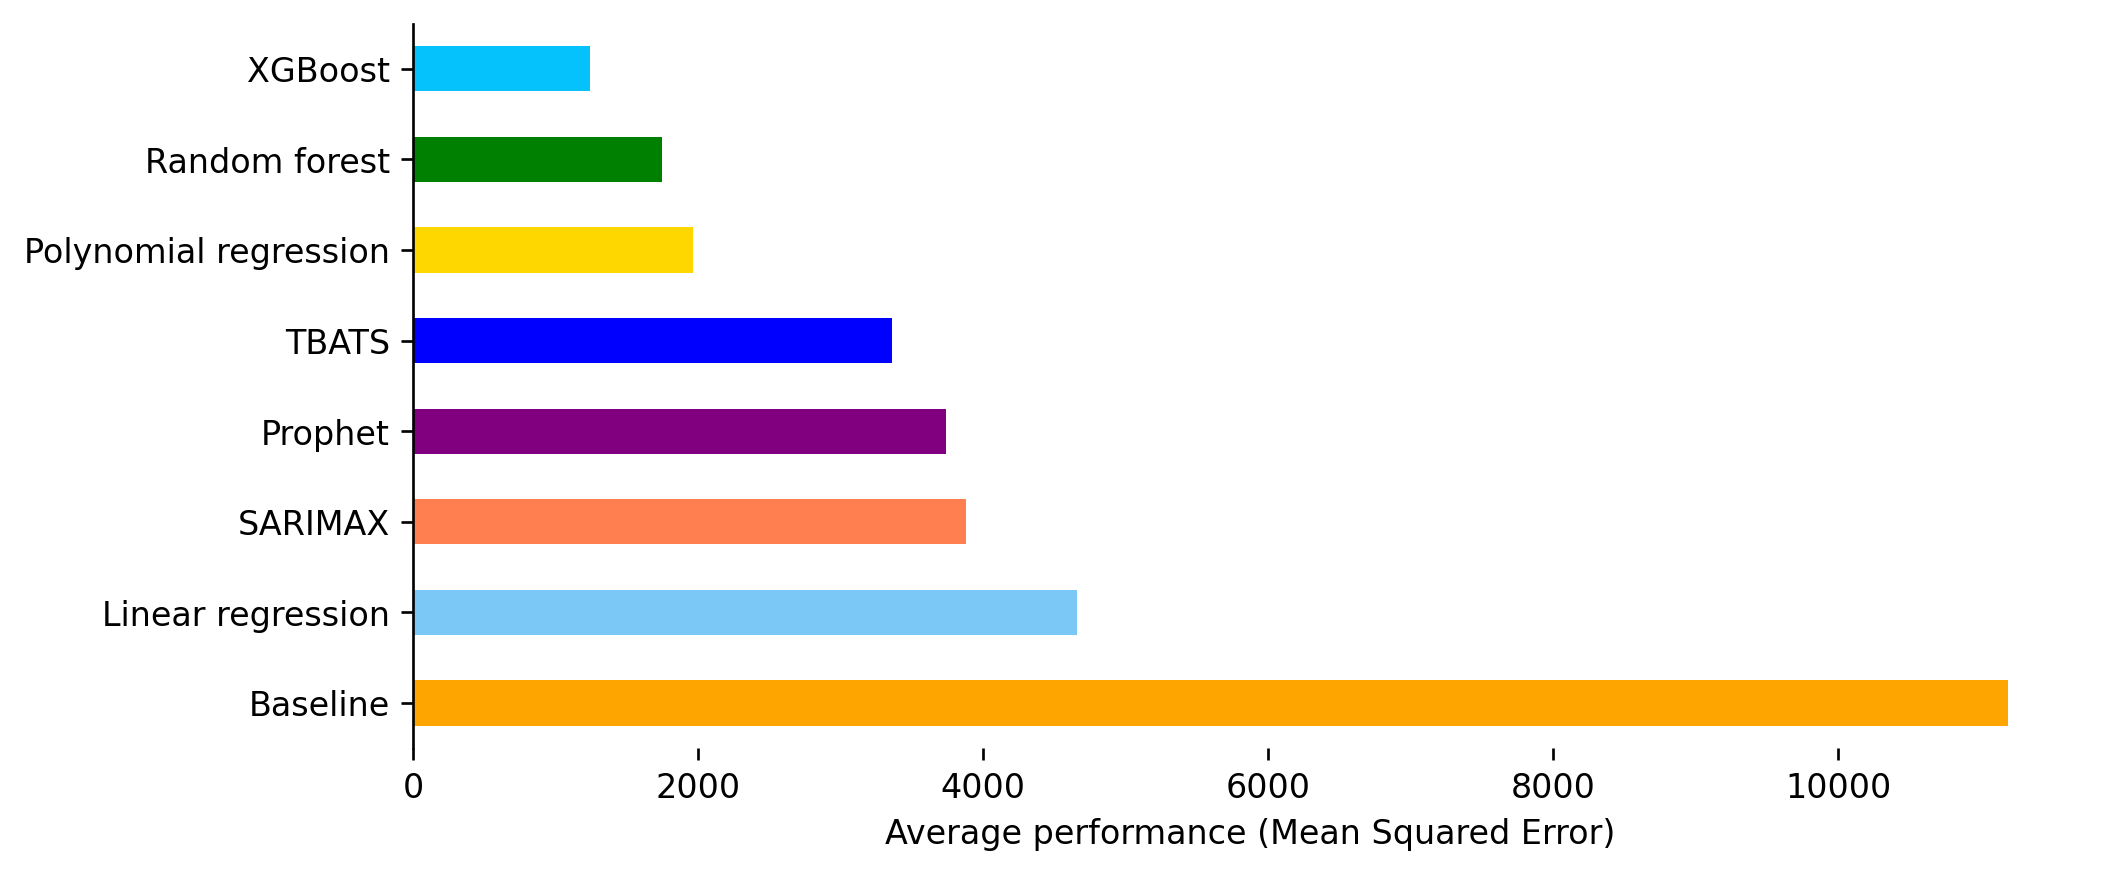

In [11]:
avg_performance = {}
for k, v in all_performances.items():
    #if k == "ARIMA":
    #    continue
    #print(k, v)
    #avg_performance[k] = [0]
    avg_performance[k] = np.mean(v) #TODO: check if I am overwriting sth here
mmses = pd.concat([pd.DataFrame({"model": [k], "mmse": [v]}) for k, v in avg_performance.items()], axis=0)
mmses = mmses.sort_values("mmse", ascending=False)

#mmses["color"] = mmses.model.map(lambda x: model2color.get(x, "black"))
mmses["color"] = mmses.model.map(lambda x: selectors[x]["disp_color"])

fig, ax = plt.subplots()
fig.set_figheight(4)
fig.set_figwidth(9)
fig.set_dpi(240)

mmses["disp_label"] = mmses.model.map(lambda x: selectors[x]["disp_label"])

mmses.plot.barh(x="disp_label", y="mmse", color=mmses["color"], ax=ax)
ax.set_xlabel("Average performance (Mean Squared Error)")
ax.set_ylabel("")
ax.legend().remove()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

In [12]:
# Load the actual dataset
def get_df(building_nr, feature):
    if building_nr == "all":
        filename = "Agg_buildings.csv"
    else:
        filename = f"Building_{building_nr}.csv"
    df = (
    pd.read_csv(Path("../data/preprocessed") / filename)
        .astype({'datetime': 'datetime64'})
        [[feature, "datetime"]]
        .rename(columns={feature: "actual"})
    )
    df.index.name = "id"
    return df

actual_df = get_df(BUILDING_NR, "net_load_kW")

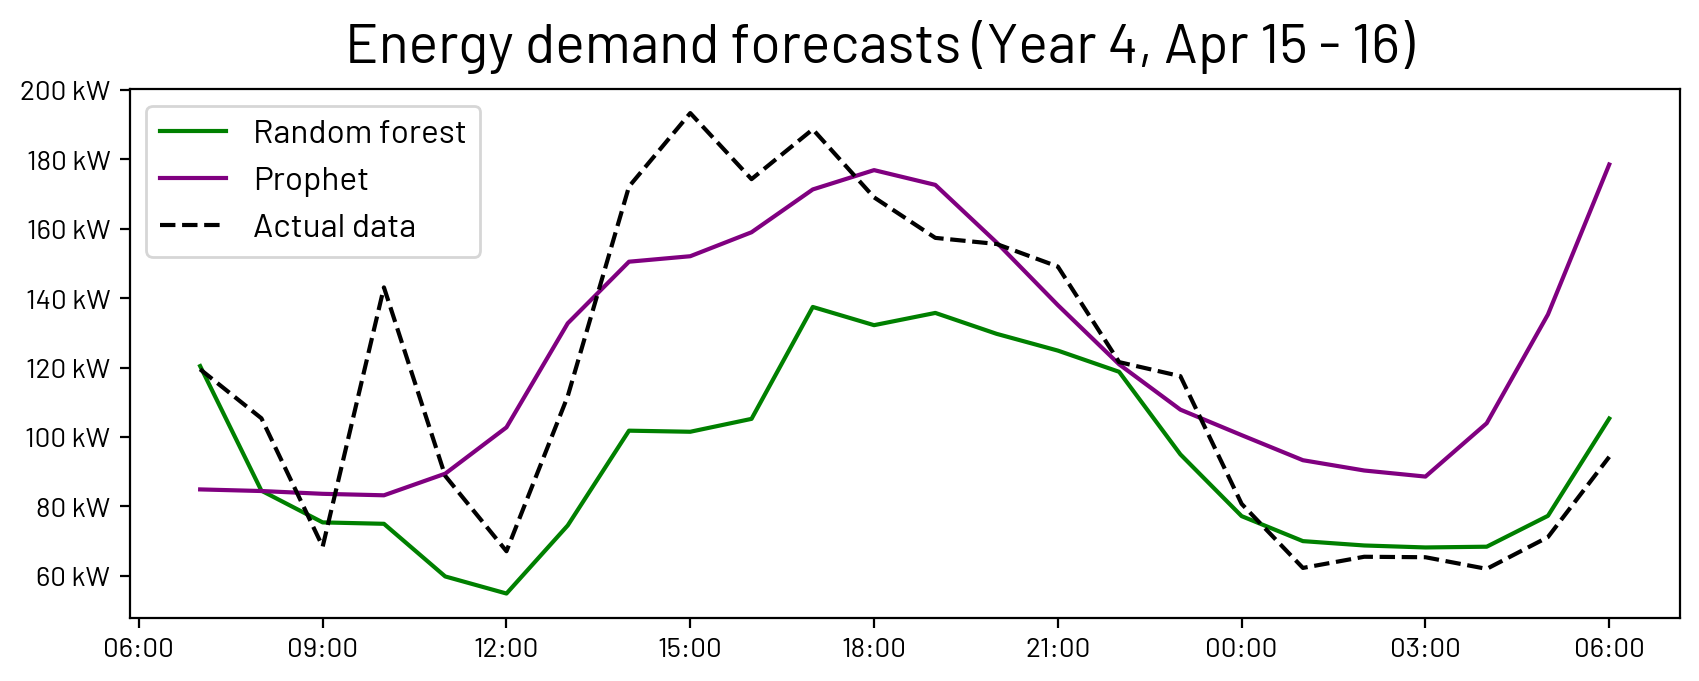

In [19]:
import matplotlib.font_manager as font_manager
#plt.rcParams['figure.figsize'] = [25, 6]
plt.rcParams['figure.figsize'] = [10, 3.5]
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['figure.dpi'] = 200
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Barlow']

#font = {
#    #'family': 'serif',
#    #'family': 'Barlow',
#    'color':  'darkred',
#    'weight': 'normal',
#    'size': 12,
#}
#mngr_font = font_manager.FontProperties(
#    #family='Barlow',
#    #family='serif',
#    #color="darkread",
#    weight="normal",
#    size=12,
#)

#index_to_plot = INDEX_LINEPLOT
index_to_plot = indices[2] #2 or 3
#index_to_plot = indices[1]
plot_performances = all_performances_df[all_performances_df["time_index"] == index_to_plot]
plot_df = df[df["index"] == index_to_plot].drop_duplicates(subset=["run_name"])
#display(plot_df)
#display(plot_performances)
#print(plot_performances.shape)
#display(all_performances_df)
#print(all_performances_df.shape)
from pandas import concat

df_from_csv_1 = pd.read_csv("../data/results/linear_regression.csv")
df_from_csv_2 = pd.read_csv("../data/results/sarimax_(2,1,1)(1,0,1,24).csv")
df_from_csv = pd.concat([df_from_csv_1, df_from_csv_2], axis=0, ignore_index=True)[["runid", "id", "prediction"]].rename(columns={"runid": "run_id"})
#df_from_csv.head()

y_true = actual_df.loc[index_to_plot+1:index_to_plot+24].set_index("datetime")

#fig = plt.figure(figsize=(11,3), dpi=240)
fig = plt.figure()
ax = fig.add_subplot(111)

for run_id, run_data in plot_performances.set_index("run_index").iterrows():
    if not run_data["model"] in ["random_forest", "prophet_1"]:
        continue
#for run_id, run_data in plot_df.iterrows():
    plot_kwargs = {}
    query_string = f"SELECT * FROM forecast WHERE run_id='{run_id}'" # LIMIT 10"
    run_predictions = pd.read_sql(query_string, db).drop(columns="run_id")
    if len(run_predictions) == 0:
        print(f"[INFO: for {run_id}, there is not data in the SQL database.]")
        #print(f"[...trying to read from csv file]")
        run_predictions = df_from_csv[df_from_csv.run_id == run_id].copy().drop(columns="run_id")
        if len(run_predictions) == 0:
            print(f"[Warning: didn't find {run_id} csv data]")
            continue
    #TODO: include plot style in selectors dict
    #if run_data.run_name in ["linear_regression", "sarimax_(2,1,1)(1,0,1,24)"]:
    #if run_data.model in ["linear_regression", "sarimax_(2,1,1)(1,0,1,24)"]:
    disp_linestyle = selectors[run_data.model].get("disp_style")
    if disp_linestyle is not None:  
        plot_kwargs = {
            'linestyle': disp_linestyle
        }

    run_predictions["datetime"] = run_predictions["id"].map(index2datetime)#y_true.index
    #color = selectors[run_data['name']].get("disp_color")
    ax.plot(run_predictions.drop(columns=["id"]).set_index("datetime"), color=run_data["disp_color"], label=run_data["disp_label"], **plot_kwargs)

ax.plot(y_true, color="black", linestyle="dashed", label="Actual data");
#plt.yaxis.set_major_formatter(tick.FuncFormatter(y_fmt))
ax.legend(prop={'size': 12})
#ax.legend(prop=mngr_font)

def y_fmt(x, y):
    return f"{int(x)} kW"

#ax.set_ylim(21, 82)
#ax.set_ylim(0, 62)
#if BUILDING_NR == 'all':
#    ax.set_ylim(-50, 500)
ax.yaxis.set_major_formatter(tick.FuncFormatter(y_fmt))
date_form = DateFormatter("%H:%M")
ax.xaxis.set_major_formatter(date_form)
#fig.suptitle("Net energy usage forecasts (Year 4, Sep 2)")
#ax.legend(bbox_to_anchor=(1,0), loc="lower left")
fig.suptitle("Energy demand forecasts (Year 4, Apr 15 - 16)", size=16)
#ax.set_title('foo', fontdict=font)
plt.savefig("/Users/rafaelarndt/Desktop/outp_savefig.png")

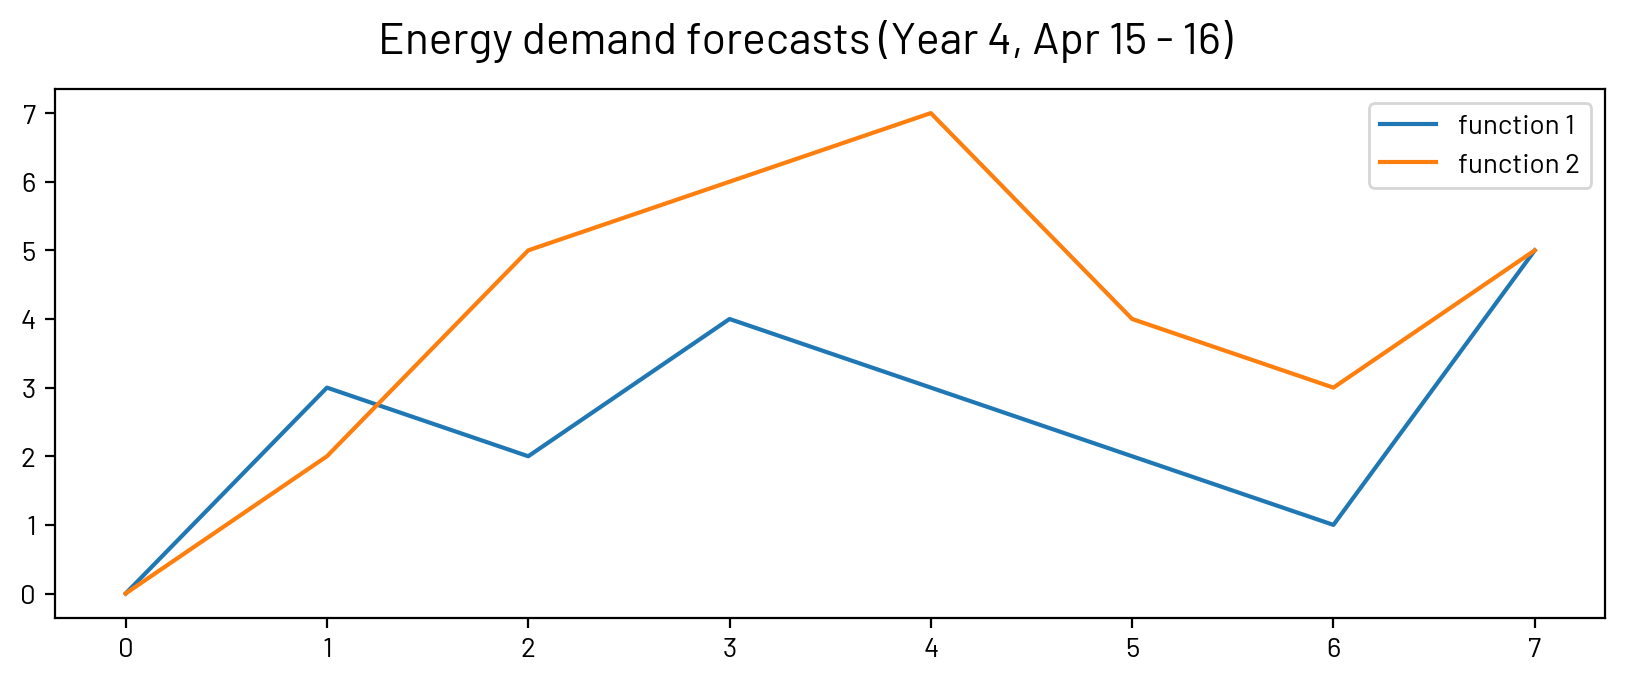

In [34]:
#The Barlow font can be downloaded from https://fonts.google.com/specimen/Barlow
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 3.5]
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['figure.dpi'] = 200
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Barlow']

fig, ax = plt.subplots()
ax.plot(list(range(8)), [0,3,2,4,3,2,1,5], label="function 1")
ax.plot(list(range(8)), [0,2,5,6,7,4,3,5], label="function 2")
fig.suptitle("Energy demand forecasts (Year 4, Apr 15 - 16)", size=16)
ax.legend(prop={'size': 10})
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)

plt.savefig("../images/tmp_test.png")
#in the google slide presentation, the image has to be scaled to ['figure.figsize'] = [10, 3.5],
# because it sometimes automatically scales to other sizes